In [3]:
import pandas as pd
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test, multivariate_logrank_test
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, roc_auc_score, confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from random import choices

In [4]:
df = pd.read_csv('NPAR6.csv')
df.head()

,subject_id,hadm_id,stay_id,intime,race,gender,age,mortality_icu,mortality_hosp,los,...,alcoholic,biliary,drug_induced,unspecified,mortality_7d,mortality_28d,mortality_90d,mortality_1y,has_kidney_disease,has_sepsis
0,19753686,29945708,30469520,2152-04-07T19:23:59,UNKNOWN,M,50,0,0,4.701343,...,0,1,1,1,0,0,0,0,0,0
1,10442603,23644640,31663173,2125-02-25T15:33:43,UNKNOWN,M,67,1,1,1.110764,...,1,0,0,1,1,1,1,1,0,1
2,15696172,21774504,36542183,2187-02-07T00:52:41,UNKNOWN,M,63,1,1,1.417917,...,0,0,0,1,1,1,1,1,0,1
3,19352969,21921993,34589708,2180-10-06T13:15:00,WHITE,F,67,1,1,1.496956,...,0,1,0,1,1,1,1,1,0,0
4,13734425,25179112,35877842,2132-09-06T09:00:00,WHITE,F,91,1,1,2.088681,...,0,1,0,1,1,1,1,1,0,0


In [5]:
df['NPAR_group'] = pd.qcut(x= df['NPAR'], q=4, labels= ['Q1', 'Q2', 'Q3', 'Q4'])
df.head(2)

,subject_id,hadm_id,stay_id,intime,race,gender,age,mortality_icu,mortality_hosp,los,...,biliary,drug_induced,unspecified,mortality_7d,mortality_28d,mortality_90d,mortality_1y,has_kidney_disease,has_sepsis,NPAR_group
0,19753686,29945708,30469520,2152-04-07T19:23:59,UNKNOWN,M,50,0,0,4.701343,...,1,1,1,0,0,0,0,0,0,Q3
1,10442603,23644640,31663173,2125-02-25T15:33:43,UNKNOWN,M,67,1,1,1.110764,...,0,0,1,1,1,1,1,0,1,Q1


In [6]:
races = {
    'UNKNOWN': 'Others',
    'UNABLE TO OBTAIN': 'Others',
    'ASIAN - CHINESE': 'Others',
    'ASIAN - SOUTH EAST ASIAN': 'Others',
    'ASIAN - ASIAN INDIAN': 'Others',
    'ASIAN - KOREAN': 'Others',
    'ASIAN': 'Others',
    'HISPANIC OR LATINO': 'Others',
    'HISPANIC/LATINO - PUERTO RICAN': 'Others',
    'HISPANIC/LATINO - GUATEMALAN': 'Others',
    'HISPANIC/LATINO - DOMINICAN': 'Others',
    'HISPANIC/LATINO - MEXICAN': 'Others',
    'HISPANIC/LATINO - SALVADORAN': 'Others',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'Others',
    'HISPANIC/LATINO - CUBAN': 'Others',
    'HISPANIC/LATINO - COLUMBIAN': 'Others',
    'HISPANIC/LATINO - HONDURAN': 'Others',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'Others',
    'AMERICAN INDIAN/ALASKA NATIVE': 'Others',
    'MULTIPLE RACE/ETHNICITY': 'Others',
    'SOUTH AMERICAN': 'Others',
    'OTHER': 'Others',
    'PATIENT DECLINED TO ANSWER': 'Others',
    'WHITE': 'White',
    'WHITE - OTHER EUROPEAN': 'White',
    'WHITE - RUSSIAN': 'White',
    'WHITE - EASTERN EUROPEAN': 'White',
    'WHITE - BRAZILIAN': 'White',
    'PORTUGUESE': 'White',
    'BLACK/AFRICAN AMERICAN': 'Black',
    'BLACK/CARIBBEAN ISLAND': 'Black',
    'BLACK/CAPE VERDEAN': 'Black',
    'BLACK/AFRICAN': 'Black',
}
df['race'] = df['race'].map(races)

In [7]:
df.head()

,subject_id,hadm_id,stay_id,intime,race,gender,age,mortality_icu,mortality_hosp,los,...,biliary,drug_induced,unspecified,mortality_7d,mortality_28d,mortality_90d,mortality_1y,has_kidney_disease,has_sepsis,NPAR_group
0,19753686,29945708,30469520,2152-04-07T19:23:59,Others,M,50,0,0,4.701343,...,1,1,1,0,0,0,0,0,0,Q3
1,10442603,23644640,31663173,2125-02-25T15:33:43,Others,M,67,1,1,1.110764,...,0,0,1,1,1,1,1,0,1,Q1
2,15696172,21774504,36542183,2187-02-07T00:52:41,Others,M,63,1,1,1.417917,...,0,0,1,1,1,1,1,0,1,Q4
3,19352969,21921993,34589708,2180-10-06T13:15:00,White,F,67,1,1,1.496956,...,1,0,1,1,1,1,1,0,0,Q1
4,13734425,25179112,35877842,2132-09-06T09:00:00,White,F,91,1,1,2.088681,...,1,0,1,1,1,1,1,0,0,Q3


In [8]:
df['duration_7d'] = np.where((df['mortality_7d'] == 0) & (df['los'] > 7), 7, df['los'])
df['duration_28d'] = np.where((df['mortality_28d'] == 0) & (df['los'] > 28), 28, df['los'])
df['duration_90d'] = np.where((df['mortality_90d'] == 0) & (df['los'] > 90), 90, df['los'])
df['duration_1y']  = np.where((df['mortality_1y']  == 0) & (df['los'] > 365), 365, df['los'])

# Phân tích Kaplan Meier
## Kiểm định Log Rank
### Hypothosic (Giả thuyết)
H0: Các Qi tương đương nhau

H1: Tồn tại Qi khác nhau

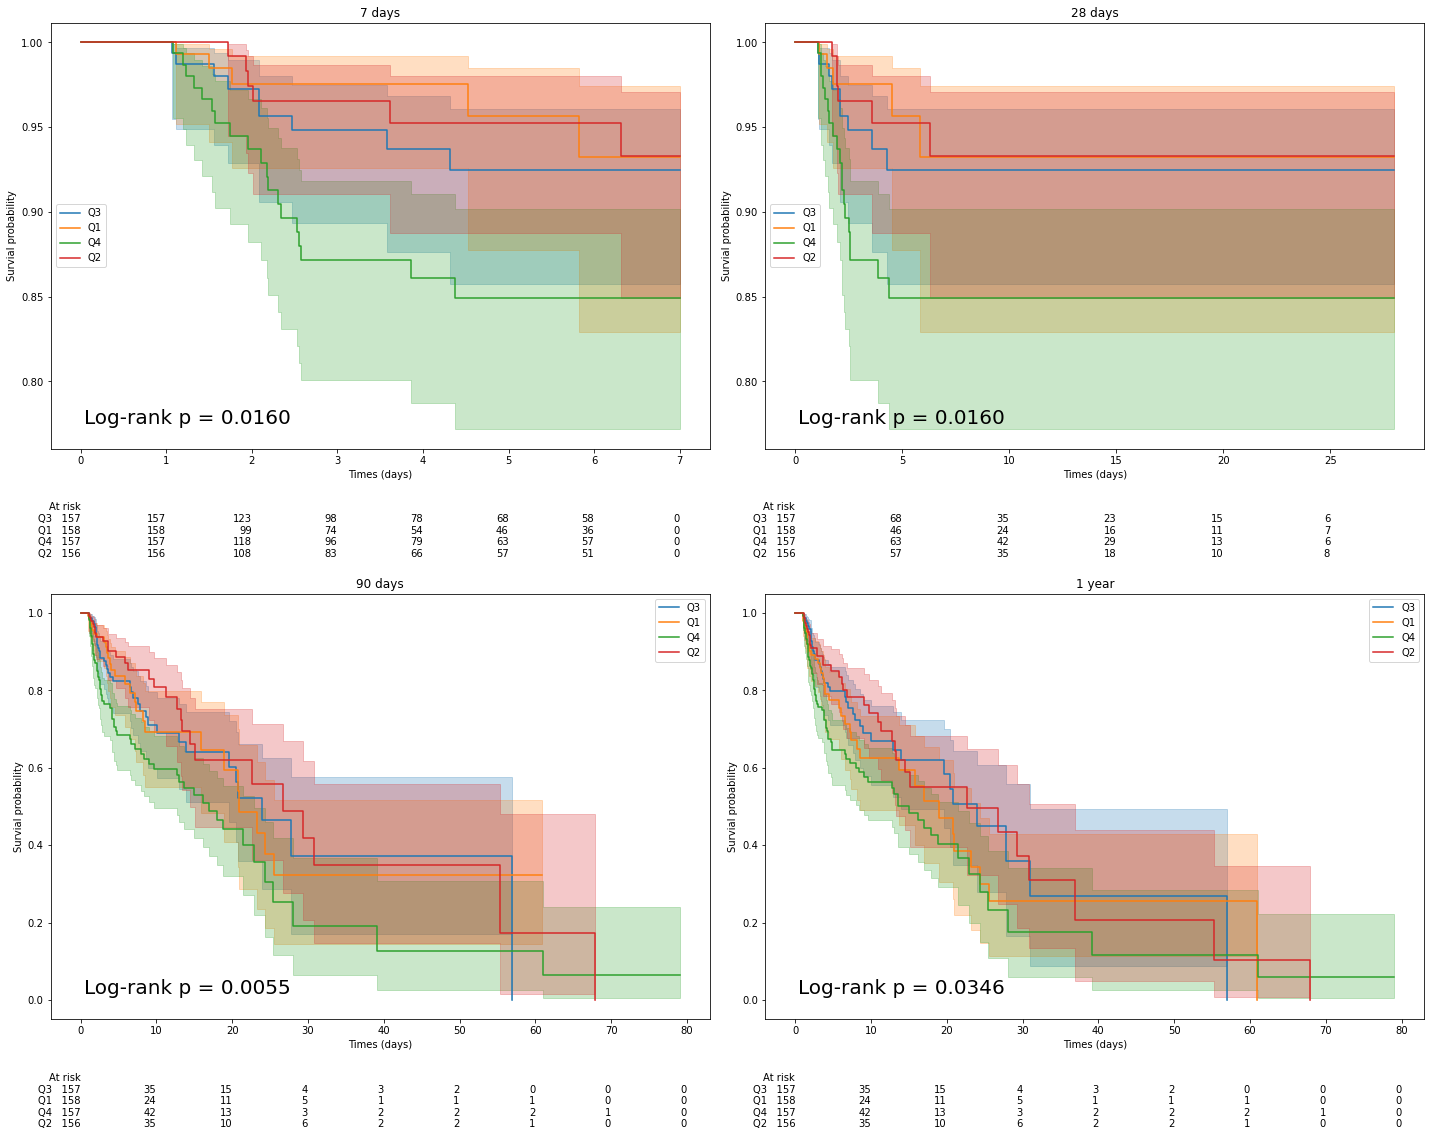

In [9]:
durations = ['duration_7d','duration_28d', 'duration_90d', 'duration_1y']
events = ['mortality_7d','mortality_7d', 'mortality_90d', 'mortality_1y']
titles = ['7 days','28 days', '90 days', '1 year']
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 16) )
axes = axes.flatten()
kmf = KaplanMeierFitter()
groups = df['NPAR_group'].unique()
for i in range(len(durations)):
    ax = axes[i]

    models = []
    for group in groups:
        kmf = KaplanMeierFitter()
        kmf.fit(durations = df[df['NPAR_group'] == group][durations[i]], event_observed = df[df['NPAR_group'] == group][events[i]], label=group)
        kmf.plot(ax=ax)
        models.append(kmf)
    results = multivariate_logrank_test(event_durations = df[durations[i]], groups = df['NPAR_group'], event_observed= df[events[i]])
    pval = results.p_value
    ax.text(0.05, 0.05, f"Log-rank p = {pval:.4f}", transform = ax.transAxes, fontsize = 20, verticalalignment = 'bottom')
    add_at_risk_counts(*models, ax = ax, rows_to_show=['At risk'], labels= groups)
    ax.set_title(titles[i])
    ax.set_ylabel('Survial probability')
    ax.set_xlabel('Times (days)')
plt.tight_layout()
plt.show()

In [10]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'race', 'gender', 'age',
       'mortality_icu', 'mortality_hosp', 'los', 'hosp_los', 'icu_los',
       'admittime', 'dod', 'inr_max', 'pt_max', 'ptt_max',
       'abs_neutrophils_max', 'abs_lymphocytes_max', 'abs_monocytes_max',
       'glucose_max', 'hematocrit_max', 'wbc_max', 'aniongap_max',
       'creatinine_max', 'sodium_max', 'potassium_max', 'bilirubin_total_max',
       'neutrophis_max', 'bun_min', 'albumin_min', 'platelets_min',
       'bicarbonate_min', 'calcium_min', 'hemoglobin_min', 'ast_max',
       'alp_max', 'bun_max', 'chloride_max', 'rdw_max', 'hdl', 'ldl',
       'cholesterol', 'triglycerides', 'alt_max', 'total_protein_max',
       'amylase_max', 'lipase', 'NPAR', 'SII', 'NLR', 'PLR', 'LMR', 'NPR',
       'SIRI', 'sapsii', 'oasis', 'sofa', 'cci', 'apsiii', 'heart_rate_mean',
       'resp_rate_mean', 'mbp_mean', 'temperature_mean', 'spo2_mean',
       'myocardial_infarct', 'congestive_heart_failure',
       'cere

# Phân tích ROC AUC
## Tiền xử lý dữ liệu

In [11]:
cols = ['NPAR', 'neutrophis_max', 'albumin_min','sapsii', 'oasis', 'sofa', 'cci', 'apsiii' ]
imp = IterativeImputer(max_iter=100)
df[cols] = imp.fit_transform(df[cols])

In [12]:
# cols = ['NPAR', 'neutrophis_max', 'albumin_min','sofa']
# imp = IterativeImputer(max_iter=100)
# df[cols] = imp.fit_transform(df[cols])

## Sử dụng Logistic Regression để phân tích đường cong ROC

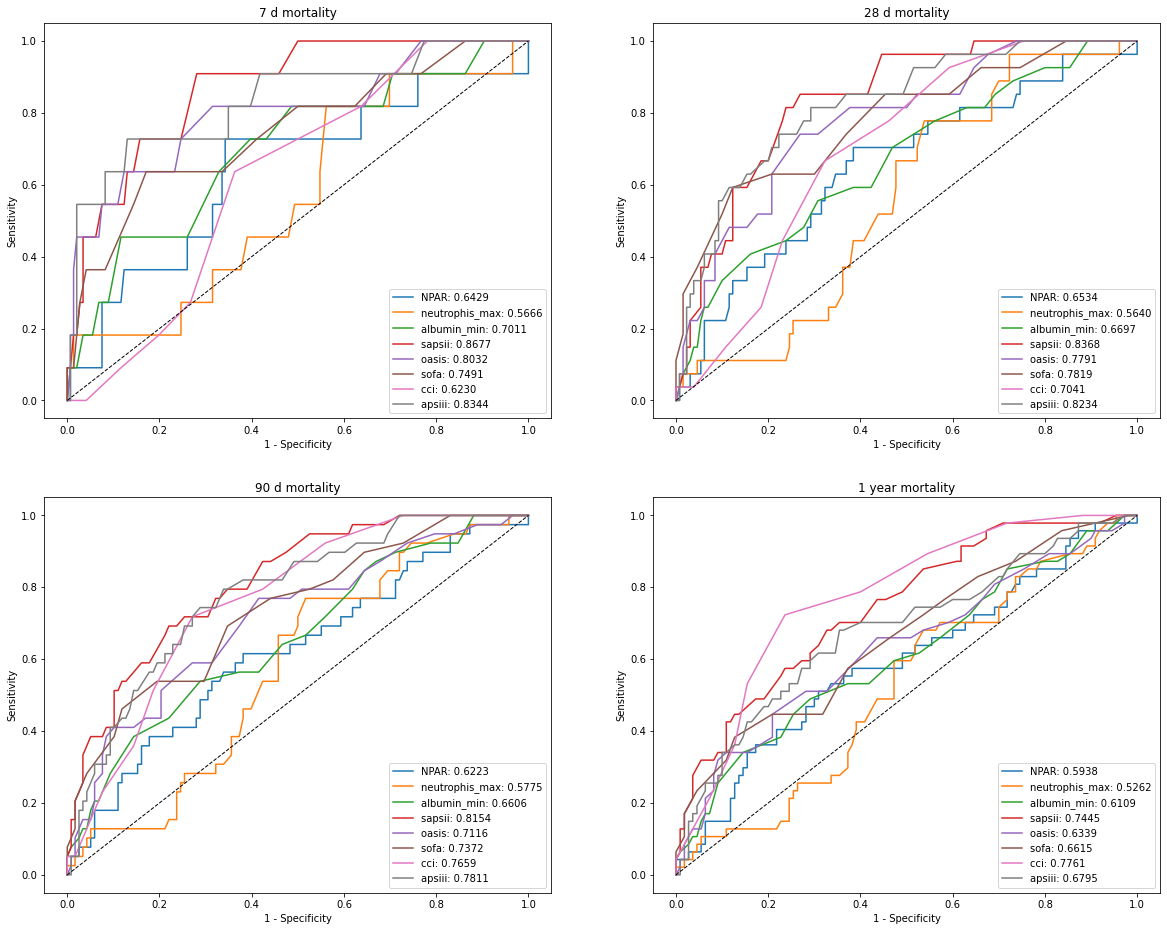

In [13]:

events = ['mortality_7d', 'mortality_28d', 'mortality_90d', 'mortality_1y']
titles = ['7 d mortality', '28 d mortality', '90 d mortality', '1 year mortality']
lr = LogisticRegression()
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 16))
axes = axes.flatten()
for i in range(len(durations)):
    ax = axes[i]
    y = df[events[i]]
    for col in cols:
        X = df[[col]]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2026)
        lr.fit(X_train, y_train)
        y_prob = lr.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = roc_auc_score(y_test, y_prob)
        ax.plot(fpr, tpr, label=f"{col}: {roc_auc:.4f}")
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
    # Tùy chỉnh đồ thị
    ax.set_xlabel("1 - Specificity")
    ax.set_ylabel("Sensitivity")
    ax.set_title(titles[i])
    ax.legend()
plt.show()

In [14]:
arr = [3, 7, 5, 4, 6, 9]
rs = []
for i in range(1000):
    brr = choices(population=arr, k=len(arr))
    rs.append(np.mean(brr))
np.quantile(rs, q=[0.25, 0.75])


array([5.        , 6.16666667])

In [15]:
arr = np.array([3, 7, 5, 4, 6, 9])
brr = np.array([6, 4, 1, 5, 4, 8])
idx = list(range(len(arr)))
idx_sel = choices(idx, k = len(arr))
arr[idx_sel], brr[idx_sel]

(array([7, 3, 6, 4, 5, 5]), array([4, 6, 4, 5, 1, 1]))

In [16]:
def boostrap(y_test, y_prob, n_sample = 1000):
    n = len(y_test)
    idx = list(range(n))
    res = []
    for i in range(n_sample):
        idx_sel = choices(population=idx, k = n)
        roc_auc = roc_auc_score(y_test[idx_sel], y_prob[idx_sel])
        res.append(roc_auc)
    return np.quantile(res, q= [0.25, 0.75])

In [17]:
events = ['mortality_7d', 'mortality_28d', 'mortality_90d', 'mortality_1y']
titles = ['7 days ', '28 days ', '90 days ', '1 year ']

lr = LogisticRegression()
results = []
for i in range(len(durations)):
    results.append({'Variables': titles[i], 'AUC (%)': '', '95%CI (%)': '', 'Threshold': '', 'Sensitivity': '', 'Specificity': ''})
    y = df[events[i]].values
    for col in cols:
        X = df[[col]]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2026)
        lr.fit(X_train, y_train)
        y_prob = lr.predict_proba(X_test)[:, 1]
        y_pred = lr.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = roc_auc_score(y_test, y_prob)
        ci_low, ci_upper = boostrap(y_test, y_prob, n_sample=500)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).flatten()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        threshold = sensitivity + specificity - 1
        results.append({'Variables': col,
                    'AUC (%)': f'{roc_auc *100: .2f}',
                    '95%CI (%)' : f'{ci_low * 100:.2f}-{ci_upper * 100:.2f}',
                    'Threshold': f'{threshold:.2f}',
                    'Sensitivity': f'{sensitivity:.2f}',
                    'Specificity': f'{specificity:.2f}'
        })
pd.DataFrame(results)
   

,Variables,AUC (%),95%CI (%),Threshold,Sensitivity,Specificity
0,7 days,,,,,
1,NPAR,64.29,57.72-70.48,0.00,0.00,1.00
2,neutrophis_max,56.66,50.22-61.85,0.00,0.00,1.00
3,albumin_min,70.11,62.72-75.90,0.00,0.00,1.00
4,sapsii,86.77,83.28-90.47,0.00,0.00,1.00
5,oasis,80.32,74.43-85.99,0.00,0.00,1.00
6,sofa,74.91,69.32-81.20,0.00,0.00,1.00
7,cci,62.30,57.64-67.29,0.00,0.00,1.00
8,apsiii,83.44,79.22-88.95,0.17,0.18,0.99
9,28 days,,,,,
